# Terminal NGP

In [4]:
import torch
import argparse
from nerf.provider import NeRFDataset
from nerf.gui import NeRFGUI
from nerf.utils import *
from functools import partial
from loss import huber_loss
from init import init
import sys

In [5]:
# ngp training
opt = init('../town3_video/')    
seed_everything(0)
assert opt.bg_radius <= 0, "background model is not implemented for --tcnn"

model = NeRFNetwork(
    encoding="hashgrid",
    bound=opt.bound,
    cuda_ray=opt.cuda_ray,
    density_scale=1,
    min_near=opt.min_near,
    density_thresh=opt.density_thresh,
    bg_radius=opt.bg_radius,
)

criterion = torch.nn.MSELoss(reduction='none')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = lambda model: torch.optim.Adam(model.get_params(opt.lr), betas=(0.9, 0.99), eps=1e-15)
train_loader = NeRFDataset(opt, device=device, type='train').dataloader()
scheduler = lambda optimizer: optim.lr_scheduler.LambdaLR(optimizer, lambda iter: 0.1 ** min(iter / opt.iters, 1))
trainer = Trainer('ngp', opt, model, device=device, workspace=opt.workspace, optimizer=optimizer, criterion=criterion, ema_decay=0.95, fp16=opt.fp16, lr_scheduler=scheduler, scheduler_update_every_step=True, metrics=[PSNRMeter()], use_checkpoint=opt.ckpt, eval_interval=50)
gui = NeRFGUI(opt, trainer, train_loader)

gui.render(500) # 500 to reach 0.55 progress

initializing TCNN


Loading train data:: 100%|████████████████████| 600/600 [00:06<00:00, 94.12it/s]


Stacking 600 poses


[INFO] Trainer: ngp | 2023-12-10_00-30-11 | cuda | fp16 | 3_command

[INFO] #parameters: 12612208

[INFO] Loading latest checkpoint ...

[WARN] No checkpoint found, model randomly initialized.

Input correspinds to: train/cam-v0-t0.jpg
MDN Path: ../town3_video/


100%|█████████████████████████████████████████| 500/500 [03:37<00:00,  2.30it/s]


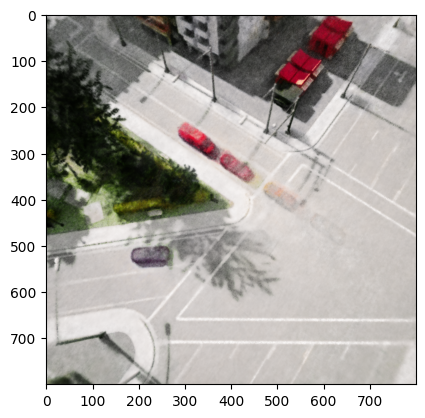

In [6]:
gui.render_bev()

Input correspinds to: train/cam-v2-t2.jpg
Success: changed to latents generated by  v2-t2


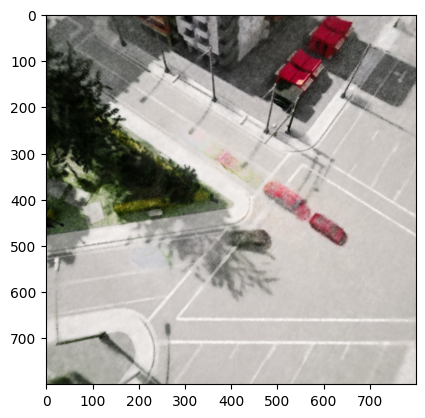

In [9]:
gui.update_latent_from_image("v2-t2")

In [ ]:
gui.update_latent_from_predicted()